100%|██████████| 170M/170M [00:01<00:00, 96.8MB/s]


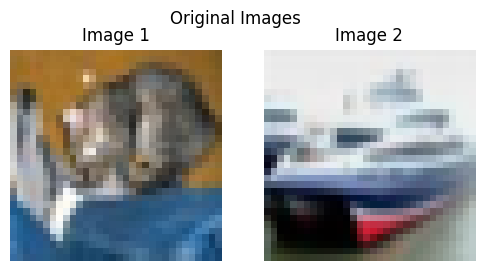


--- Original ---
Image 1: Shape=(32, 32, 3), Range=(13, 255)
Image 2: Shape=(32, 32, 3), Range=(0, 247)


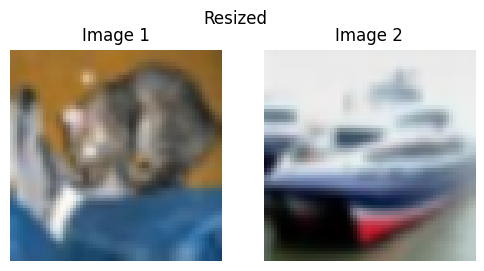


--- Resize ---
Image 1: Shape=(64, 64, 3), Range=(18, 251)
Image 2: Shape=(64, 64, 3), Range=(0, 243)


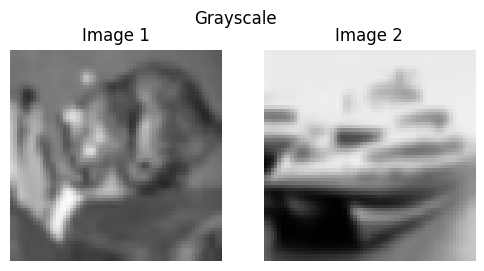


--- Grayscale ---
Image 1: Shape=(64, 64), Range=(37, 250)
Image 2: Shape=(64, 64), Range=(0, 239)


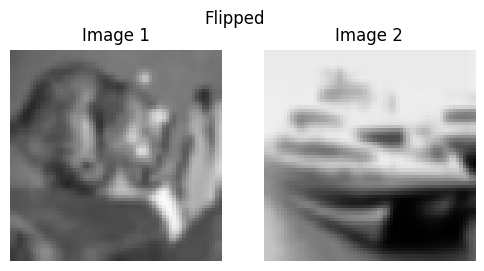


--- Flip ---
Image 1: Shape=(64, 64), Range=(37, 250)
Image 2: Shape=(64, 64), Range=(0, 239)


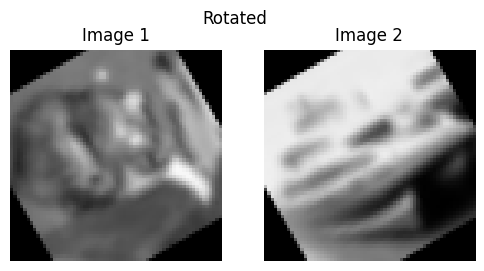


--- Rotation ---
Image 1: Shape=(64, 64), Range=(0, 248)
Image 2: Shape=(64, 64), Range=(0, 239)


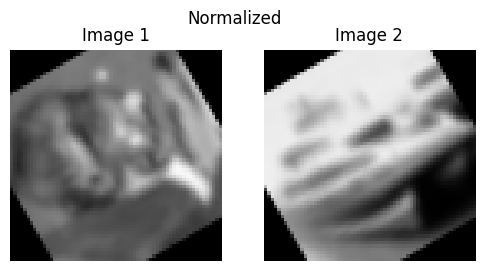


--- Normalization ---
Image 1: Shape=(64, 64), Range=(0.0, 0.9725490196078431)
Image 2: Shape=(64, 64), Range=(0.0, 0.9372549019607843)


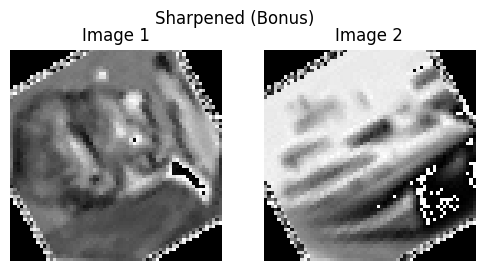


--- Sharpen Filter ---
Image 1: Shape=(64, 64), Range=(-1.380392156862745, 1.823529411764706)
Image 2: Shape=(64, 64), Range=(-1.4588235294117649, 2.1058823529411765)

Final Tensor Shape: torch.Size([2, 1, 64, 64])
Final Tensor Range: -1.458823561668396 2.105882406234741


In [1]:
# =========================
# CIFAR-10 IMAGE PREPROCESSING PIPELINE
# =========================

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2

# -------------------------
# Load CIFAR-10 Dataset
# -------------------------
dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True
)

# Select two images
img1, _ = dataset[0]
img2, _ = dataset[1]

# Convert PIL to NumPy
img1 = np.array(img1)
img2 = np.array(img2)

images = [img1, img2]
titles = ["Image 1", "Image 2"]

# Utility function
def show_images(imgs, title):
    plt.figure(figsize=(6,3))
    for i, img in enumerate(imgs):
        plt.subplot(1,2,i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(titles[i])
    plt.suptitle(title)
    plt.show()

def print_stats(imgs, step):
    print(f"\n--- {step} ---")
    for i, img in enumerate(imgs):
        print(f"Image {i+1}: Shape={img.shape}, Range=({img.min()}, {img.max()})")

# -------------------------
# Step 1: Original
# -------------------------
show_images(images, "Original Images")
print_stats(images, "Original")

# -------------------------
# Step 2: Resize (32x32 → 64x64)
# -------------------------
resized = [cv2.resize(img, (64,64)) for img in images]
show_images(resized, "Resized")
print_stats(resized, "Resize")

# -------------------------
# Step 3: Grayscale
# -------------------------
grayscale = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in resized]
grayscale_rgb = [cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) for img in grayscale]
show_images(grayscale_rgb, "Grayscale")
print_stats(grayscale, "Grayscale")

# -------------------------
# Step 4: Horizontal Flip
# -------------------------
flipped = [cv2.flip(img, 1) for img in grayscale]
flipped_rgb = [cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) for img in flipped]
show_images(flipped_rgb, "Flipped")
print_stats(flipped, "Flip")

# -------------------------
# Step 5: Rotation (30°)
# -------------------------
def rotate(img):
    h, w = img.shape
    M = cv2.getRotationMatrix2D((w//2, h//2), 30, 1)
    return cv2.warpAffine(img, M, (w, h))

rotated = [rotate(img) for img in flipped]
rotated_rgb = [cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) for img in rotated]
show_images(rotated_rgb, "Rotated")
print_stats(rotated, "Rotation")

# -------------------------
# Step 6: Normalization (0–1)
# -------------------------
normalized = [img / 255.0 for img in rotated]
norm_rgb = [cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_GRAY2RGB) for img in normalized]
show_images(norm_rgb, "Normalized")
print_stats(normalized, "Normalization")

# -------------------------
# BONUS: Custom Sharpening Filter
# -------------------------
kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])

sharpened = [cv2.filter2D(img, -1, kernel) for img in normalized]
sharp_rgb = [cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_GRAY2RGB) for img in sharpened]
show_images(sharp_rgb, "Sharpened (Bonus)")
print_stats(sharpened, "Sharpen Filter")

# -------------------------
# Convert to Tensor [B, C, H, W]
# -------------------------
tensor_imgs = []
for img in sharpened:
    img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
    tensor_imgs.append(img)

batch_tensor = torch.stack(tensor_imgs)

print("\nFinal Tensor Shape:", batch_tensor.shape)
print("Final Tensor Range:", batch_tensor.min().item(), batch_tensor.max().item())


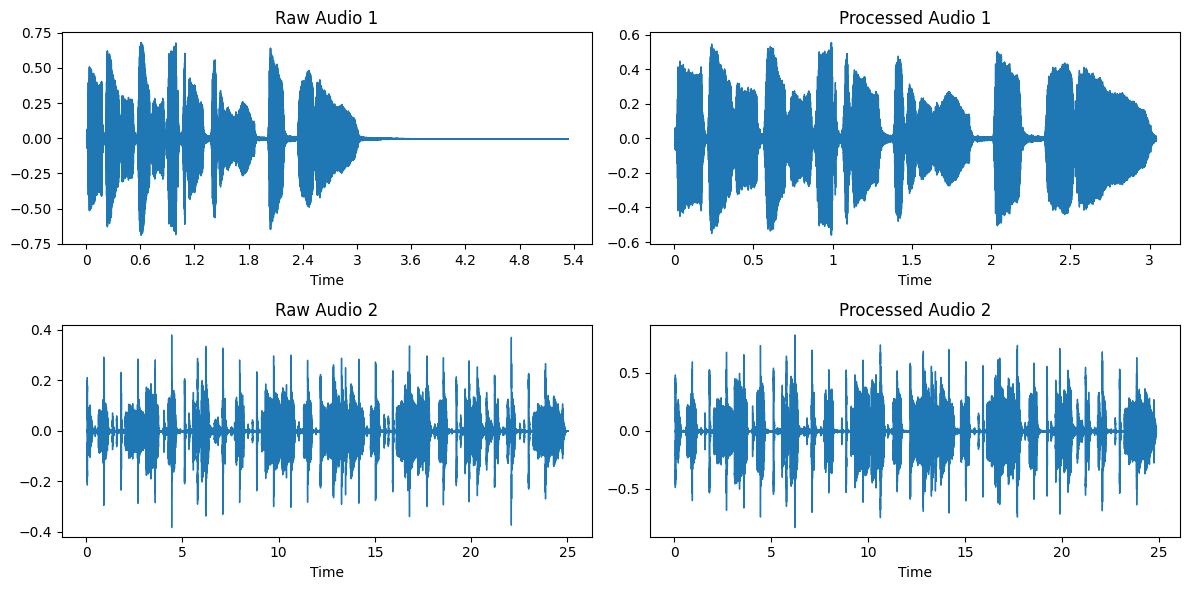

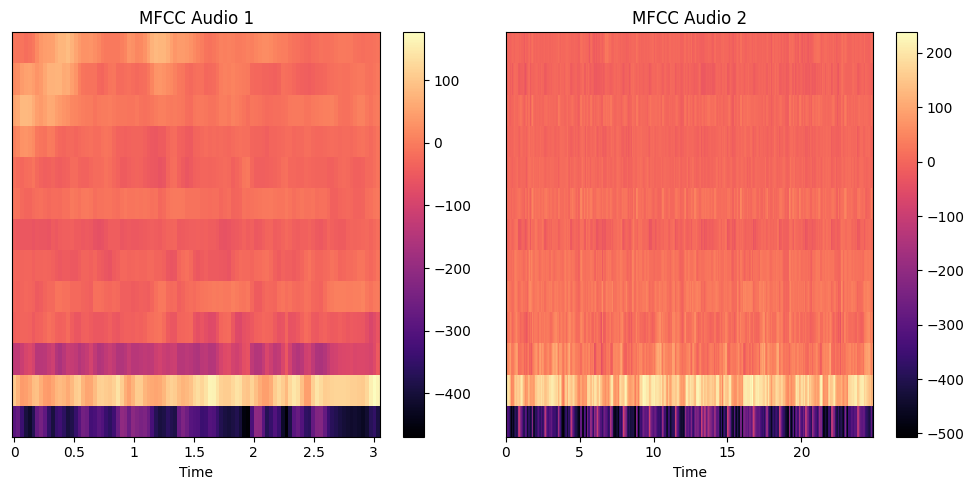

Features Tensor Shape: (2, 13, 96)
Value Range: -491.7842847844872 214.56667051445984


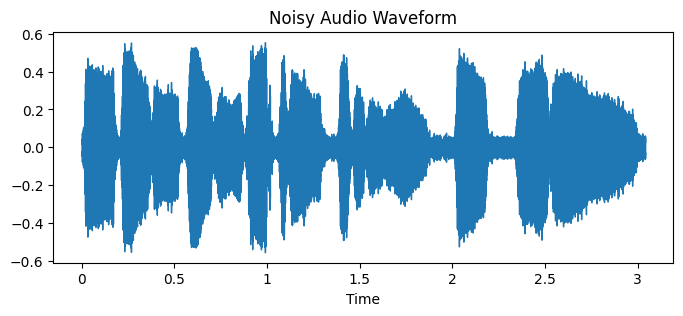

In [3]:
# ==========================================
# SPEECH PREPROCESSING WITH LIBROSA ONLY
# ==========================================

import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Load Two Audio Samples
# -------------------------------
# librosa.example() downloads internally (no urllib used)
audio_path1 = librosa.ex('trumpet')
audio_path2 = librosa.ex('choice')

y1, sr1 = librosa.load(audio_path1, sr=None)
y2, sr2 = librosa.load(audio_path2, sr=None)

raw_audios = [(y1, sr1), (y2, sr2)]

# -------------------------------
# Preprocessing Functions
# -------------------------------
def normalize(audio):
    return audio / np.max(np.abs(audio))

# Simple smoothing filter (moving average)
def smoothing_filter(audio, kernel_size=5):
    kernel = np.ones(kernel_size) / kernel_size
    return np.convolve(audio, kernel, mode='same')

# -------------------------------
# Preprocessing Pipeline
# -------------------------------
processed_audios = []
target_sr = 16000

for audio, sr in raw_audios:
    # Resample to 16 kHz
    audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)

    # Normalize
    audio = normalize(audio)

    # Silence trimming
    audio, _ = librosa.effects.trim(audio, top_db=20)

    # Smoothing filter
    audio = smoothing_filter(audio)

    processed_audios.append(audio)

# -------------------------------
# Visualization: Raw vs Processed
# -------------------------------
plt.figure(figsize=(12,6))

for i in range(2):
    plt.subplot(2,2,i*2+1)
    librosa.display.waveshow(raw_audios[i][0], sr=raw_audios[i][1])
    plt.title(f"Raw Audio {i+1}")

    plt.subplot(2,2,i*2+2)
    librosa.display.waveshow(processed_audios[i], sr=target_sr)
    plt.title(f"Processed Audio {i+1}")

plt.tight_layout()
plt.show()

# -------------------------------
# Feature Extraction (MFCC)
# -------------------------------
mfccs = []

plt.figure(figsize=(10,5))

for i, audio in enumerate(processed_audios):
    mfcc = librosa.feature.mfcc(
        y=audio,
        sr=target_sr,
        n_mfcc=13
    )
    mfccs.append(mfcc)

    plt.subplot(1,2,i+1)
    librosa.display.specshow(
        mfcc,
        x_axis='time',
        sr=target_sr,
        cmap='magma'
    )
    plt.colorbar()
    plt.title(f"MFCC Audio {i+1}")

plt.tight_layout()
plt.show()

# -------------------------------
# Combine Features into One Tensor
# -------------------------------
min_len = min(m.shape[1] for m in mfccs)
mfccs = [m[:, :min_len] for m in mfccs]

features_tensor = np.stack(mfccs)

print("Features Tensor Shape:", features_tensor.shape)
print("Value Range:", features_tensor.min(), features_tensor.max())

# -------------------------------
# BONUS: Noise Experiment
# -------------------------------
noise = 0.02 * np.random.randn(len(processed_audios[0]))
noisy_audio = processed_audios[0] + noise

plt.figure(figsize=(8,3))
librosa.display.waveshow(noisy_audio, sr=target_sr)
plt.title("Noisy Audio Waveform")
plt.show()
